In [107]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

datos = pd.read_csv("admission_data.csv")
dfdatos = pd.DataFrame(datos, columns = datos.columns)

#separar variables independientes de la independiente
X = dfdatos.drop("Chance of Admit", axis = 1)
y = dfdatos ["Chance of Admit"]

#separar datos de entrenamiento y datis de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =  0.3, random_state = 1234)
#Crear y entrenar el modelo
modelo = LinearRegression()
modelo.fit(X_train, y_train)

#Hacer predicciones usando el modelo
predicciones = modelo.predict(X_test)



In [62]:
#Calculo de metricas
mse = mean_squared_error(y_test,predicciones)
mae = mean_absolute_error(y_test, predicciones)
srmse = np.sqrt(mse)

#Imprimir metricas 
print("Error Absoluto Medio: ", mae)
print("Error  Cuadratico Medio: ", mse)
print("Raiz del Error Cuadratico Medio: ", srmse)

Error Absoluto Medio:  0.04364488605510547
Error  Cuadratico Medio:  0.003907582992571896
Raiz del Error Cuadratico Medio:  0.06251066303097333


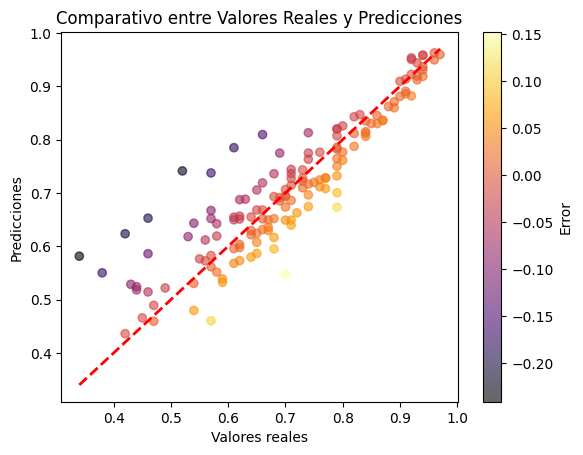

In [63]:


#Visualizacion del error
plt.scatter(y_test,
            predicciones,
            c = (y_test - predicciones),
            cmap = "inferno",
            alpha = 0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
          'r--',
           lw = 2)
plt.colorbar (label = "Error")
plt.xlabel("Valores reales")
plt.ylabel("Predicciones")
plt.title("Comparativo entre Valores Reales y Predicciones")
plt.show()

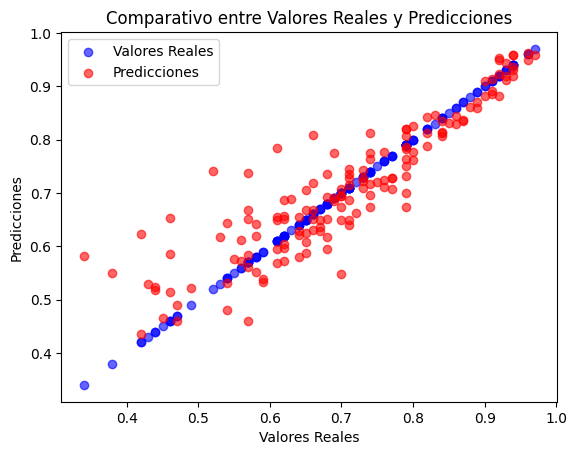

In [64]:

# Visualizar los valores reales y las predicciones con diferentes colores
plt.scatter(y_test, y_test, color='blue', alpha=0.6, label='Valores Reales')
plt.scatter(y_test, predicciones, color='red', alpha=0.6, label='Predicciones')

# Etiquetas y título del gráfico
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Comparativo entre Valores Reales y Predicciones")
plt.legend()

# Mostrar el gráfico
plt.show()

In [65]:
#Estandarizar las variables
escala = StandardScaler()
X_scaled = escala.fit_transform(X)

#Validacion cruzada
vc = cross_val_score (modelo,
                      X_scaled, 
                      y, 
                      cv = 5,
                      scoring = "neg_mean_squared_error")
vc_raiz = np.sqrt(-vc)
print("Resultado de la Validacion Cruzada: ", vc_raiz)
print("Error Promedio: ", vc_raiz.mean())

Resultado de la Validacion Cruzada:  [0.09902431 0.05558946 0.04116535 0.0586372  0.04293221]
Error Promedio:  0.059469705647307435


In [72]:
param_grid = {
    #numero de arboles
    'n_estimators': [50, 100, 200],
    #profundidad e cada arbol
    'max_depth': [10, 20, None],
    #minimo numero de subconjuntos de los los datos
    'min_samples_split': [2, 5, 10]
}

modelo_optimizado  = RandomForestRegressor(random_state = 42)

#Busqueda en la malla
busqueda = GridSearchCV(modelo_optimizado,
                       param_grid,
                       cv = 5,
                       scoring = "neg_mean_squared_error")

busqueda.fit(X_train, y_train)

#Resultados
print("Mejores parametros: ", busqueda.best_params_)
print("Mejor tamano de error: ", -busqueda.best_score_)
print("Eror cuadratico: ", np.sqrt(-busqueda.best_score_))

Mejores parametros:  {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 50}
Mejor tamano de error:  0.004040801822493554
Eror cuadratico:  0.0635673015196772


In [81]:
#Entrenar el modelo con los mejores parametros
modelo_final = busqueda.best_estimator_
modelo_final.fit(X_train, y_train)

#Hacer predicciones con el modelo optimizado
predicciones = modelo_final.predict(X_test)
errores = np.sqrt(mean_squared_error(y_test, predicciones))
print("Raiz cuadrada del error del mejor modelo: ", errores)

Raiz cuadrada del error del mejor modelo:  0.06766859353372978


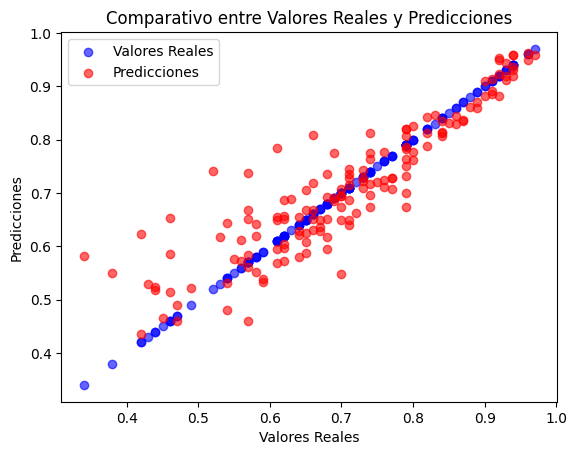

In [85]:
#Visualizacion de las diferencias los valores reales y predicciones del nuevo modelo
plt.scatter(y_test, y_test, color='blue', alpha=0.6, label='Valores Reales')
plt.scatter(y_test, predicciones, color='red', alpha=0.6, label='Predicciones')

# Etiquetas y título del gráfico
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Comparativo entre Valores Reales y Predicciones")
plt.legend()

# Mostrar el gráfico
plt.show()


In [97]:
#Metodo de clasificacion por Regresion Logistica

#Establecer el umbral de clasificacion
umbral = (y >= 0.9).astype(int)

#Dividir los datos
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_scaled, umbral, test_size=0.2, random_state = 42)

#Entrenamiento y ajuste del modelo
modelo_logistico = LogisticRegression()
modelo_logistico.fit(X_train_bin, y_train_bin)

#Prediccion  y evaluacion
predicciones_logisticas = modelo_logistico.predict(X_test_bin)

#Precision del modelo
print("Precision: ", accuracy_score(y_test_bin, predicciones_logisticas))
#Capacidad del modelo para clasificar
print("F1  Score: : ", f1_score(y_test_bin, predicciones_logisticas))
print("Matriz de confusion: ", confusion_matrix(y_test_bin, predicciones_logisticas))



Precision:  0.98
F1  Score: :  0.9285714285714286
Matriz de confusion:  [[85  1]
 [ 1 13]]


In [101]:
#Seleccion de las variables mas relevantes
selector = SelectKBest (score_func = f_regression, k=5)
X_selectas = selector.fit_transform(X_scaled, y)

print("Puntajes de importancia de las variables: ", selector.scores_)
print("Variables seleccionadas: ", X.columns[selector.get_support()])

Puntajes de importancia de las variables:  [ 952.4917137   839.36006853  452.8946661   438.16551237  355.46364342
 1751.85042916  211.37662942]
Variables seleccionadas:  Index(['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'CGPA'], dtype='object')


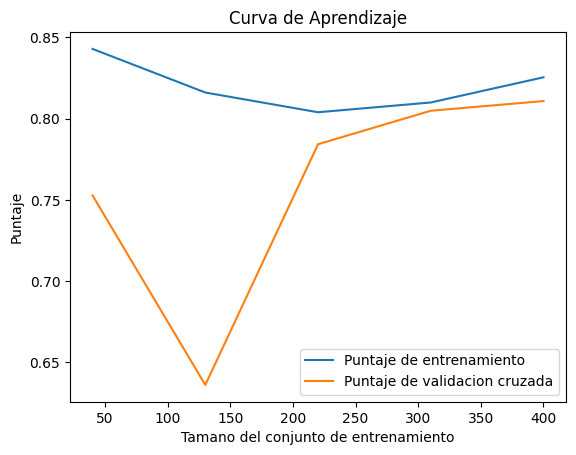

In [105]:
#Curvas de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(modelo, X_scaled, y, cv = 5)

#Calcular el promedio de scores de entrenamiento y prueba
media_train = np.mean(train_scores, axis = 1)
media_test = np.mean(test_scores, axis = 1)

#Visualizamos los puntajes
plt.plot(train_sizes, media_train, label = "Puntaje de entrenamiento")
plt.plot(train_sizes, media_test, label = "Puntaje de validacion cruzada")
plt.xlabel("Tamano del conjunto de entrenamiento")
plt.ylabel("Puntaje")
plt.legend()
plt.title("Curva de Aprendizaje")
plt.show()

In [109]:
#Regularizacion de ajustes del modelo de regresion

#Ridge: evita los sobreajustes, que vaya poco a poco en los ajustes de los coeficientes, nunca los deja en 0
#Lasso: penaliza el ajuste de las variables que no so importantes

#Ridge 
modelo_ridge = Ridge(alpha =  1.0)
modelo_ridge.fit(X_train, y_train)
print("Raiz cuadrada del modelo Ridge: ", np.sqrt(mean_squared_error(y_test, modelo_ridge.predict(X_test))))

#Lasso
modelo_lasso = Lasso (alpha = 1.0)
modelo_lasso.fit(X_train, y_train)
print("Raiz cuadrada del modelo Lasso: ", np.sqrt(mean_squared_error(y_test, modelo_lasso.predict(X_test))))



Raiz cuadrada del modelo Ridge:  0.06234213400558316
Raiz cuadrada del modelo Lasso:  0.12542153321973237
